#Project Overview

###Problem Definition
**Objective:** Use data science and machine learning to create a classification model that is able to predict which passengers survived the Titanic shipwreck using available data ranging from age to sex to ticket price.

###Relevant Domain Insights

*   On April 15, 1912 the "unsinkable" RMS Titanic sank after colliding with an iceberg
*   There weren't nearly enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew
*   Although there were some elements of luck involved in survivinm **it seemed that some groups of people were more likely to surviv ethan others** (i.e. women, children, and the upper-class)





#Import Libraries

In [1]:
#Import all relevant libraries
import pandas as pd
import numpy as np
import plotly.express as px
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

#Acquire Data

In [2]:
#Training and test datasets
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#Analyze Data (Perform Exploratory Data Analysis)

In [3]:
#see an exemplar of the first five entries
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


###Notable Insights from .info()


*   Age (20% of entries missing data)
*   Cabin (77% of entries missing data)
*   Embarked (<1% of entries missing data)



In [4]:
#Understand amount of missing entries and data types for each feature
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


###Notable Insights from .describe()

*    The training dataset contains 891 passengers, 40% of the total passengers aboard the ship (2224)
*    38% of the training dataset survived, compared to 32% of all passengers
*    The majority of passengers (>50%) were classified as “lower” in socio-economic standing (Pclass = 3)
*    Over 99% of passengers were under the age of 65
*    Almost 70% of passengers travelled without any siblings or spouses
*    Over 75% of passengers did not travel with parents or children
*    Fares varied dramatically from $6 – $512


In [5]:
#Distribution of numerical data at 2nd, 25th, 50th, 75th, and 99th percentile
df_train.describe(percentiles=[.02, .25, .5, 0.75, .99])

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
2%,18.800000,0.000000,1.000000,2.000000,0.000000,0.000000,6.397500
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
99%,882.100000,1.000000,3.000000,65.870000,5.000000,4.000000,249.006220
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


###Distribution of Categorical Data Features
*    65% of passengers in the dataset are male
*    72% passengers embarked at Southampton

In [6]:
#distribution of categorical data (of type 'Object')
df_train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Penasco y Castellana, Mr. Victor de Satode",male,347082,G6,S
freq,1,577,7,4,644


##Assumptions based on data analysis:
Correlating
*    Want to correlate each feature with survival (the output label)

Completing 
*    Consider filling in missing values for age (likely correlated to survival)
*    We should also consider filling in the missing values for embarked features as it may also correlate with survival or other important features

Correcting 
*    The *Tickets* feature may need to be dropped as it contains 23% (210/891) duplicate entries
*    The cabin feature may need to be dropped as the majority of entries contain a null value for it
*    PassengerId can be dropped as it merely an ordering of passengers with no relation to survival
*    Passenger name is relatively trivial, so it can be dropped

Creating 
*    A new feature called Family could be created that combines *Parch* and *SibSp* to gt the total number of family members on board for each passenger
*    Could create age ranges that turn the continuous numerical data of age into a more discrete list of categories
*    Could also create a *Fare* range if it helps analysis

Classifying (Assumptions)
*          Women (Sex = female) more likely to survive
*          Children (Age < ?) more likely to survive
*          Upper-class (Pclass = 1) more likely to survive

##Assumptions by pivoting features:
Next stage can be used to further hone in on assumptions made above by analyzing the correlation of features to the dependent variable (survival). At the moment, this can only be done for features containing no missing values, and that are categorical (nominal or ordinal) or discrete (cannot do continuous)

In [7]:
#Survival rates by sex
Sex_pivot = df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Sex', ascending=False)

Sex_pivot

,Sex,Survived
1,male,0.188908
0,female,0.742038


In [8]:
for i in range(len(Sex_pivot)):
  print(f"The likelihood of survival for a {Sex_pivot.columns[0]} = {Sex_pivot.loc[i][0]} passenger was {round(Sex_pivot.loc[i][1]*100,2)}%")

The likelihood of survival for a Sex = female passenger was 74.2%
The likelihood of survival for a Sex = male passenger was 18.89%


In [9]:
#Survival rates by socio-economic class
Pclass_pivot = df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Pclass_pivot

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [10]:
for i in range(len(Pclass_pivot)):
  print(f"The likelihood of survival for a {Pclass_pivot.columns[0]} = {Pclass_pivot.loc[i][0]} passenger was {round(Pclass_pivot.loc[i][1] * 100,2)}%")

The likelihood of survival for a Pclass = 1.0 passenger was 62.96%
The likelihood of survival for a Pclass = 2.0 passenger was 47.28%
The likelihood of survival for a Pclass = 3.0 passenger was 24.24%


In [11]:
#Survival rates by number of Siblings and Spouses
sameAge_pivot = df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

sameAge_pivot

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [12]:
for i in range(len(sameAge_pivot)):
  print(f"The likelihood of survival for a {sameAge_pivot.columns[0]} = {sameAge_pivot.loc[i][0]} passenger was {round(sameAge_pivot.loc[i][1]*100,2)}%")

The likelihood of survival for a SibSp = 0.0 passenger was 34.54%
The likelihood of survival for a SibSp = 1.0 passenger was 53.59%
The likelihood of survival for a SibSp = 2.0 passenger was 46.43%
The likelihood of survival for a SibSp = 3.0 passenger was 25.0%
The likelihood of survival for a SibSp = 4.0 passenger was 16.67%
The likelihood of survival for a SibSp = 5.0 passenger was 0.0%
The likelihood of survival for a SibSp = 8.0 passenger was 0.0%


In [13]:
#Survival rates by number of children and parents
youngAndOld_pivot = df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

youngAndOld_pivot

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [14]:
for i in range(len(youngAndOld_pivot)):
  print(f'The likelihood of survival for a {youngAndOld_pivot.columns[0]} = {youngAndOld_pivot.loc[i][0]} passenger was {round(youngAndOld_pivot.loc[i][1]*100,2)}%')

The likelihood of survival for a Parch = 0.0 passenger was 34.37%
The likelihood of survival for a Parch = 1.0 passenger was 55.08%
The likelihood of survival for a Parch = 2.0 passenger was 50.0%
The likelihood of survival for a Parch = 3.0 passenger was 60.0%
The likelihood of survival for a Parch = 4.0 passenger was 0.0%
The likelihood of survival for a Parch = 5.0 passenger was 20.0%
The likelihood of survival for a Parch = 6.0 passenger was 0.0%


##Analyze by visualizing data


###Survivability based on age
Confirm assumptions surrounding the correlations between features and our solution goal/dependent variable/label (*Survived*):


*   Large number of passengers from ages 17.5 - 32.5 did not survive
*   Young children (<7 years old) had relatively high survival rates
*   Based on these results, it is clear that **age certainly plays a factor in survival** and thus, **null values should be corrected in order to factor this data into the model**



In [15]:
#Survival rates by age (banded into 20 bins)
age = px.histogram(df_train, x='Age', facet_row='Survived', range_x=[0,100], nbins=20)
age

###Survivability based on age and socio-economic class


*   Pclass = 3 had the most passengers, most did not survive
*   Infant passengers in Pclass 2 & 3 had high survival rates (relatively)
*   Most passengers in Pclass = 1 survived
*   Pclass had variation in age distribution of passengers
*   **Consider Pclass for model training**



In [16]:
#Passenger outcome by age and social class
socioEcon = px.histogram(df_train, x='Age', facet_row='Pclass', facet_col='Survived', nbins=20)
socioEcon

###Survivability based on where passengers embarked

*   Confirms assumption that, for the most part, females had much better survival 
rates than males 
*   **Consider Sex in model training**
*   **Complete and add Embarked as a feature to model training**

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the pointplot function without specifying `order` is likely to produce an incorrect plot.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:648: UserWarning:

Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.



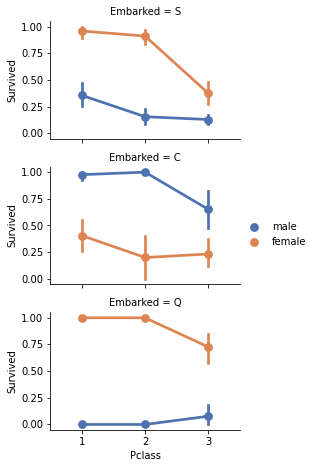

In [17]:
#Survival rates by port of embarkation (and sex)
grid = sns.FacetGrid(df_train, row='Embarked', size=2.2, aspect=1.6)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

###Correlating categorical and numerical features
*   Can consider correlating Embarked, Sex, Fare, with Survived
*   Higher fare paying passengers had better survival
*   Port of embarkation correlates with survival rates
*   **Worth banding Fare feature**

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:316: UserWarning:

The `size` parameter has been renamed to `height`; please update your code.

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



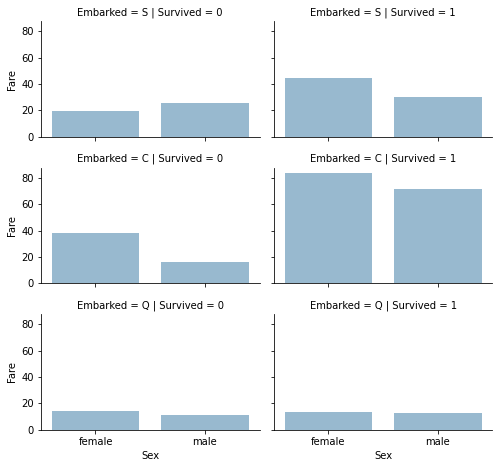

In [18]:
#Survival rates by sex, fare, and port of embarkation 
numerous = sns.FacetGrid(df_train, row='Embarked', col='Survived', size=2.2, aspect=1.6)
numerous.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

#Wrangle data

Having now accepted or rejected our hypotheses, we can move forward with correcting, creating, and completing goals as needed

*    Start by dropping features so that we deal with fewer data points (and leave out anything that’s not useful)

*    It is clear that Cabin and Ticket can be dropped from the dataset

In [19]:
#Show shape of the dataset (and combine into a list for simple iteration when 
#need  to apply same function over both the training and testing data sets)
print("Before: ", df_train.shape, df_test.shape)

df_train = df_train.drop(['Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Ticket', 'Cabin'], axis=1)
combine = [df_train, df_test]

print("After: ", df_train.shape, df_test.shape)

Before:  (891, 12) (418, 11)
After:  (891, 10) (418, 9)


Before dropping the Name feature, we want to see if any useful information can be extracted from titles (i.e. Mr. Ms. Mrs.)

*    Use a regular expression to take all words right before a period ( [A-Za-z]+)\.

In [20]:
#Use Regex to obtain the tite for each passenger
for dataset in combine:
  dataset['Title'] = dataset['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

#print all found titles and their respective frequencies depending on Sex
pd.crosstab(df_train['Title'], df_train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


17 Titles were found, but only a few were used on many occasions so convert the others to their more common version (Ms to Miss) or classify them as Rare (i.e. Dr.)

In [21]:
#Replace rare prefix names with single title 'Rare' and uncommon versions with more common (Ms -> Miss)
for dataset in combine:
  dataset['Title'] = dataset['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Rev', 'Sir'], 'Rare')

  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')

df_train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Title,Survived
3,Mrs,0.793651
1,Miss,0.702703
0,Master,0.575000
4,Rare,0.347826
2,Mr,0.156673


Convert categorical titles to ordinal (if there is no title, assign 0)

Convert categorical features into numerical values

Start estimating and completing features with missing or null values.


In [22]:
#Map each of the categories into an ordinal set of numbers
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Master': 4, 'Rare': 5}
for dataset in combine:
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)

df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [23]:
#Drop passenger ID and name from the DataFrame
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)
df_test = df_test.drop(['Name'], axis=1)
combine= [df_train, df_test]

In [24]:
#Convert the categorical Sex feature into a discrete numerical feature
for dataset in combine:
  dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1}).astype(int)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


In [25]:
#Looking at age (to find average to fill in missing values) as a function of Pclass and Sex
medianAge = px.histogram(df_train, x='Age', facet_row='Pclass', facet_col='Sex', nbins=20)
medianAge

###When estimating numeric data there tends to be three potential methods:
1.    Generate a random number between the mean and standard deviation
2.    Use other correlated features, guess age values using median values for age across sets of Pclass and Gender feature combinations 
3.    Combine methods 1 and 2, so use random numbers between mean and standard deviation, based on sets of Pclass and Gender combinations 


In [26]:
#Prepare an empty array to contain guessed Age values based on Pclass and Sex combinations
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [27]:
#Iterate over sex
for dataset in combine:
  for i in range(0,2):
    for j in range(0,3):
      guess_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

      age_guess = guess_df.median()

      guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
    
  for i in range(0,2):
    for j in range(0,3):
      dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1), 'Age'] = guess_ages[i,j]

  dataset['Age'] = dataset['Age'].astype(int)

df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int64  
 3   Age       891 non-null    int64  
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
 8   Title     891 non-null    int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 62.8+ KB


In [28]:
#Created age bands (turn continuous data into discrete data) and correlate with survival
df_train['AgeBand'] = pd.cut(df_train['Age'], 5)
df_train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


In [29]:
#Change Age to ordinal values reflecting the AgeBands
for dataset in combine:
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[ (dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[ (dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[ (dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


In [30]:
#Can now remove AgeBand
df_train = df_train.drop(['AgeBand'], axis=1)
combine = [df_train, df_test]
df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


###Create new feature combining existing features 
We want a simple “FamilySize” feature that combines the information from “Parch” (parents and children) and “SibSp” (siblings and spouses)


In [31]:
#create the new feature "FamilySize" that summarizes data from the aforementioned two
for dataset in combine:
  #add one to include the passenger in the family size
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

df_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived',ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [32]:
#Drop all other family information (as that is now summarized in the FamilySize data point)
df_train = df_train.drop(['Parch', 'SibSp'], axis=1)
df_test = df_test.drop(['Parch', 'SibSp'], axis=1)
combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,1,7.2500,S,1,2
1,1,1,1,2,71.2833,C,3,2
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,2
4,0,3,0,2,8.0500,S,1,1


###Fill in missing locations for port of embarkation
Because this is only two entries, we can simply fill with the most popular value (the mode)

In [33]:
#Fill 2 missing port of embarkation entries (out of 891) with the most common appearance
freq_port = df_train['Embarked'].mode()[0]
freq_port

'S'

In [34]:
#Fill in missing port-of-embarkation data with 'S'
for dataset in combine:
  dataset.loc[ dataset['Embarked'].isnull(), 'Embarked'] = freq_port

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Embarked    891 non-null    object 
 6   Title       891 non-null    int64  
 7   FamilySize  891 non-null    int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 55.8+ KB


In [35]:
#Survival rate by port of embarkation
embarkation_S = df_train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)
embarkation_S

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Convert the categorical feature into a discrete numerical value for port of embarkation

In [36]:
#Convert categorical data into numerical data
for dataset in combine:
  dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'Q':1, 'C':2}).astype(int)

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,1,7.2500,0,1,2
1,1,1,1,2,71.2833,2,3,2
2,1,3,1,1,7.9250,0,2,1
3,1,1,1,2,53.1000,0,3,2
4,0,3,0,2,8.0500,0,1,1


Fill in the one missing fare value in the test dataset using the median from the df_test DataFrame

In [37]:
#Filling in missing data for Fare from test dataset 
df_test['Fare'].fillna(df_test['Fare'].dropna().median(), inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    int64  
 4   Fare         418 non-null    float64
 5   Embarked     418 non-null    int64  
 6   Title        418 non-null    float64
 7   FamilySize   418 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 26.2 KB


Since fare is continuous, it can now be converted into discrete categories through banding 

In [38]:
#banding the fare feature
df_train['FareBand'] = pd.qcut(df_train['Fare'], 4)

df_train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


Converted the now discrete, banded fares into ordinal categories

In [39]:
#Translate banded intervals into ordinal numbers 
for dataset in combine:
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[ (dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[ (dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3

df_train.drop(['FareBand'], axis=1, inplace=True)

combine = [df_train, df_test]

df_train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,0,3,0,1,0.0,0,1,2
1,1,1,1,2,3.0,2,3,2
2,1,3,1,1,1.0,0,2,1
3,1,1,1,2,3.0,0,3,2
4,0,3,0,2,1.0,0,1,1


#Modelling
The next step is to train a model and predict the required solution (i.e. whether the passenger will survive given their various other features). In this case, this will be supervised Machine Learning as the labels have names. We will be performing classification as we are predicting whether someone will survive or not (classified as survived, or did not survive).

The models we will test out are:


*   Logistic regression
*   K-Nearest Neighbours
*   Support Vector Machines
*   Decision Tree
*   Random Forest
*   XGB Classifier


In [40]:
df_test

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,FamilySize
0,892,3,0,2,0.0,1,1.0,1
1,893,3,1,2,0.0,0,3.0,2
2,894,2,0,3,1.0,1,1.0,1
3,895,3,0,1,1.0,0,1.0,1
4,896,3,1,1,1.0,0,3.0,3
...,...,...,...,...,...,...,...,...
413,1305,3,0,1,1.0,0,1.0,1
414,1306,1,1,2,3.0,2,0.0,1
415,1307,3,0,2,0.0,0,1.0,1
416,1308,3,0,1,1.0,0,1.0,1


In [41]:
X_train = df_train.drop("Survived", axis=1)
Y_train = df_train['Survived']
X_test = df_test.drop("PassengerId", axis=1)
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

###Logistic Regression

It's best to begin with logistic regression because it measures the relationship between categorical dependent variable (whether person survived) and one or more independent variables (features) through estimating probabilities 


In [42]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred1 = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

print(f"{acc_log}%")

81.71%


###Calculate the coefficients in the decision function 
This step will indicate how important each variable is in the final prediction of whether the passenger will survive or not
*    Sex is by far the most predictive of survival
*    Pclass is also strongly, as Pclass increases survival decrease (larger value of Pclass is associated with “lower class” passenger)
*    Title and Age also have strong correlation 


In [43]:
#create dataframe
coeff_df = pd.DataFrame()

#First column is a list of all the features (independent variables)
coeff_df['Feature'] = df_train.columns.delete(0)

#Second column is a Pandas series 
coeff_df['Correlation'] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.243017
5,Title,0.497115
3,Fare,0.247682
4,Embarked,0.217178
6,FamilySize,-0.376560
2,Age,-0.655044
0,Pclass,-0.936631


In [44]:
df_test['Survived'] = Y_pred1
df_test1 = df_test[['PassengerId', 'Survived']]
df_test1

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


###Support Vector Machine

In [45]:
#Support Vector Machine

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred2 = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print(f"{acc_svc}%")

83.39%


In [46]:
df_test['Survived'] = Y_pred2
df_test2 = df_test[['PassengerId', 'Survived']]
df_test2

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


###K-Nearest Neighbours

In [47]:
knn = KNeighborsClassifier(n_neighbors= 3)
knn.fit(X_train, Y_train)
Y_pred3 = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(f"{acc_knn}%")

86.2%


In [48]:
df_test['Survived'] = Y_pred3
df_test3 = df_test[['PassengerId', 'Survived']]
df_test3

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


###Decision Tree

In [49]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred4 = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(f"{acc_decision_tree}%")

88.55%


In [50]:
df_test['Survived'] = Y_pred4
df_test4 = df_test[['PassengerId', 'Survived']]
df_test4

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,0
415,1307,0
416,1308,0


###Random Forest

In [51]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred5 = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train)*100, 2)
print(f"{acc_random_forest}%")

88.55%


In [52]:
df_test['Survived'] = Y_pred5
df_test5 = df_test[['PassengerId', 'Survived']]
df_test5

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


###XGBoost Classifier

In [53]:
xgbclassifier = XGBClassifier()
xgbclassifier.fit(X_train, Y_train)
Y_pred6 = xgbclassifier.predict(X_test)

In [54]:
df_test['Survived'] = Y_pred6
df_test6 = df_test[['PassengerId', 'Survived']]
df_test6

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


###Model Evaluation

In [55]:
#DataFrame containing accuracy of all models
models = pd.DataFrame({
    'Model' : ['Support Vector Machines', 'KNN', 'Logistic Regression',
    'Random Forest', 'Decision Tree'],
    'Score' : [acc_svc, acc_knn, acc_log, acc_random_forest, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,88.55
4,Decision Tree,88.55
1,KNN,86.20
0,Support Vector Machines,83.39
2,Logistic Regression,81.71




#Old Models (No longer needed, ignore this section)

###Importing


In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()
df_train = df_train[['PassengerId', 'Survived', 'Pclass', 'Sex', 'SibSp', 'Parch']]
df_train = df_train.dropna()
df_train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch
0,1,0,3,male,1,0
1,2,1,1,female,1,0
2,3,1,3,female,0,0
3,4,1,1,female,1,0
4,5,0,3,male,0,0


###Encoding categorical data

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [ ]:
df_train['Sex'] = le.fit_transform(df_train['Sex'])
df_train['Sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: Sex, dtype: int64

###Splitting Features and Label

In [ ]:
X = df_train.iloc[:, 2:].values
y = df_train.iloc[:,1].values
print(X)

[[3 1 1 0]
 [1 0 1 0]
 [3 0 0 0]
 ...
 [3 0 1 2]
 [1 1 0 0]
 [3 1 0 0]]


###Split Data into Training and Testing Set

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

###Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

###Training

Logistic Regression Model

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
fclassifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
fclassifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

###Predicting the Test set results

In [ ]:
#Logistic regression
y_pred = classifier.predict(X_test)

#Random forest
y_pred2 = fclassifier.predict(X_test)

###Making a confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[94  9]
 [29 47]]


0.7877094972067039

In [ ]:
cm = confusion_matrix(y_test, y_pred2)
print(cm)
accuracy_score(y_test, y_pred2)

[[94  9]
 [30 46]]


0.7821229050279329

#Testing Models (No longer needed, ignore this section)

###Splitting 

In [ ]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [ ]:
df_testing = df_test[['Pclass', 'Sex', 'SibSp', 'Parch']]

In [ ]:

df_testing['Sex'] = le.fit_transform(df_testing['Sex'])
X_submit = df_testing.values


X_submit = sc.fit_transform(X_submit)
print(len(X_submit))

418


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
y_submit = classifier.predict(X_submit)

#df_test = df_test['PassengerId']
df_test['Survived'] = y_submit
df_test = df_test[['PassengerId', 'Survived']]

In [ ]:
y_submit = fclassifier.predict(X_submit)

#df_test = df_test['PassengerId']
df_test['Survived'] = y_submit
df_test = df_test[['PassengerId', 'Survived']]

In [ ]:
df_test

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


#Save Dataframe as CSV for submission

In [ ]:
#Save the dataframe to a csv file to be submitted to Kaggle
df_test6.to_csv('submission10.csv', index=False)